In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.svm import NuSVR
import math
from sklearn.multioutput import MultiOutputRegressor


- "Changes in cell composition underlie diverse physiological states of metazoans and their complex tissues. For example, in malignant tumors, levels of infiltrating immune cells are associated with tumor growth, cancer progression and patient outcome1,2."
- "Common methods for studying cell heterogeneity, such as immunohistochemistry and flow cytometry, rely on a limited repertoire of phenotypic markers, and tissue disaggregation prior to flow cytometry can lead to lost or damaged cells, altering results3."

In [2]:
cell_mixes = pd.read_csv('./data/cell_mixes.csv', index_col=0)
# raw ground truth data sums to 100
ground_truth = pd.read_csv('./data/ground_truth_proportions.csv', index_col=0) / 100

# If ground truth comes from flow cytomtery, then why does Newman complain
# flow cytometry is not accurate?
ground_truth_cols = ground_truth.columns
signature_matrix = pd.read_csv('./data/signature_matrix.csv', index_col=0)

# add cell types that were not measured with flow cytometry for ground truth
for fig_col in signature_matrix.columns:
    if fig_col not in ground_truth.columns:
        ground_truth[fig_col] = 0

assert len(ground_truth.columns) == len(signature_matrix.columns)

Signature matrix vs mixes normalization

- A leukocyte gene signature matrix

- https://en.wikipedia.org/wiki/Peripheral_blood_mononuclear_cell

"Negative SVR regression coefficients are subsequently set to zero (as done for LLSR), and the remaining regression coefficients are normalized to sum to 1, yielding a final vector of estimated cell type fractions, f (notably, f denotes relative, not absolute fractions of each cell type from B in m). To decrease running time and promote better overall performance, both B and m are each normalized to zero mean and unit variance prior to running CIBERSORT. As previously suggested for other linear deconvolution methods, CIBERSORT works best on expression values in non-log linear space20."

more normalization: 
https://www.nature.com/articles/s41467-020-19015-1

 what about quantile normalization?

# Analysis

The cell deconvolution problem is:
 ?? Talk about linearity assumption:

They constructed a signature matrix pre-selecting genes that are good discriminators based on 2-norm condition number

$$

SP = M

$$

where $S$ is a signature matrix of shape #genes x #cell types, $M$ is a matrix of bulk-RNAseq cell mixes (#genes X #mixes) $P$ is an unknown matrix of relative proportion coefficients (#cell types x #mixes).

This assumes that the mixes are a linear combinations of the cell types in the signature matrix. 

TODO: solving vs estimating OLS

To find be we solve the equation for $P$: 
$$
P = S^{-1}M
$$

Want an orthonormal basis for the signature matrix (or as close as possible), to distinguish between cell types. Visualize below: not bad but could be improved.

<Axes: >

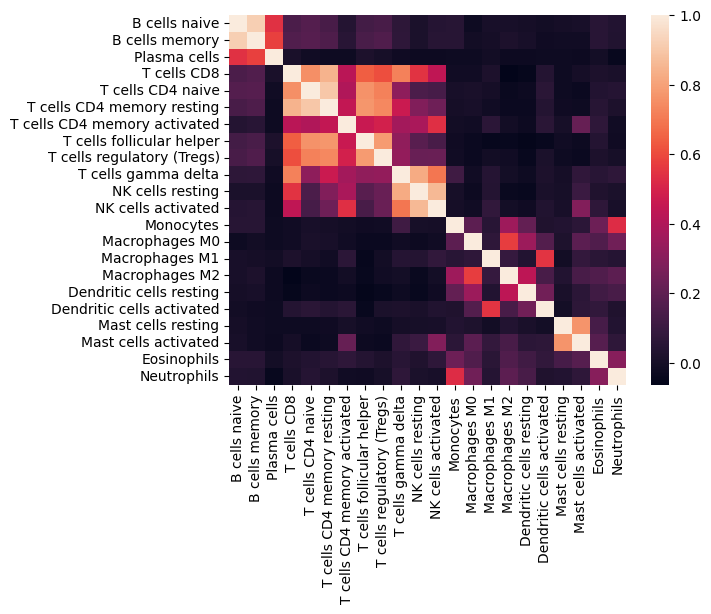

In [3]:
sns.heatmap(signature_matrix.corr())

In [4]:
# Only use genes that are measured in both cell mixes and the signature matrix
common_genes = list(signature_matrix.index.intersection(cell_mixes.index))
cell_mixes_common = cell_mixes.loc[common_genes]
# TODO: time vs .solve()
# TODO: pinv vs LinearRegression(fit_intercept=False, positive=True)
signature_matrix_common = signature_matrix.loc[common_genes]
estimated_proportions = np.linalg.pinv(signature_matrix_common) @ cell_mixes_common
estimated_proportions.index = signature_matrix.columns   # type: ignore 
# TODO check this with OLS
estimated_proportions.columns = ground_truth.T.columns   # type: ignore 

# Negative proportion values appear in normalized proportions
(estimated_proportions / estimated_proportions.sum()).head()

Sample ID,17-002,17-006,17-019,17-023,17-026,17-027,17-030,17-034,17-040,17-041,17-042,17-043,17-045,17-047,17-054,17-055,17-057,17-058,17-060,17-061
B cells naive,0.212646,0.217532,0.097099,0.214019,0.139102,0.170012,0.073152,0.103201,0.186854,0.142648,0.056805,0.197311,0.207145,0.299083,0.171278,0.088288,0.183130,0.286330,0.160011,0.120446
B cells memory,-0.095222,-0.118495,0.036038,-0.098130,-0.035549,-0.039285,0.005059,-0.036494,-0.095090,-0.051372,-0.018136,-0.113114,-0.085173,-0.181274,-0.063990,-0.059485,-0.076120,-0.140710,-0.072334,-0.053315
Plasma cells,0.083965,0.057810,0.028873,0.102160,0.142680,0.113670,0.067582,0.131308,0.153379,0.087640,0.090411,0.108097,0.101798,0.120391,0.129318,0.161083,0.099909,0.108524,0.068043,0.111977
T cells CD8,0.214198,0.223763,0.234635,0.077765,0.195770,0.248094,0.240717,0.083742,0.147840,0.115336,0.104408,0.030294,0.077709,0.024638,0.138512,0.122143,0.362337,0.146689,0.204439,0.187603
T cells CD4 naive,-0.352643,-0.382384,-0.225045,-0.333257,-0.308113,-0.365790,-0.308593,-0.189708,-0.340263,-0.200122,-0.375947,-0.247695,-0.232715,-0.350509,-0.163102,-0.206622,-0.342414,-0.272985,-0.454250,-0.229056


In [5]:
estimated_proportions[estimated_proportions < 0] = 0.0
estimated_proportions = estimated_proportions / estimated_proportions.sum()
# ensure the sum of all proportions is 1
assert (round(estimated_proportions.sum()) != 1).sum() == 0

In [6]:
# Question: scoring done in Newman is a bit too favorable to the method
# because it does not look at cell types not measured by flow cytometry
def score_estimates(estimated_proportions, ground_truth):
    cors = []
    p_vals = []
    ROW_SIZE = 4
    fig, axes = plt.subplots(2,ROW_SIZE, figsize=(15,8))
    for i, mix in enumerate(ground_truth[ground_truth_cols].columns):
        p = estimated_proportions.T[mix]
        g = ground_truth[mix]
        pr = sp.stats.pearsonr(p, g)
        cors.append(pr.statistic)
        p_vals.append(pr.pvalue)
        fig_row = math.floor(i / ROW_SIZE)
        fig_col = (i - fig_row * ROW_SIZE)
        ax = axes[fig_row][fig_col]
        sns.regplot(x=p, y=g, ax=ax)
        ax.set_title(mix)
        ax.set_ylabel('Ground Truth')
        ax.set_xlabel('Prediction')
    fig.set_tight_layout(tight='pad')
    plt.show()
    print(pd.DataFrame([cors, p_vals], index=['Mean Pearsonr', 'Mean pvalue']).T.mean())

    sns.heatmap(estimated_proportions.T)
    plt.show()
    sns.heatmap(ground_truth[estimated_proportions.T.columns])
    plt.show()

/Users/luke/projects/cell-type-deconvolution/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


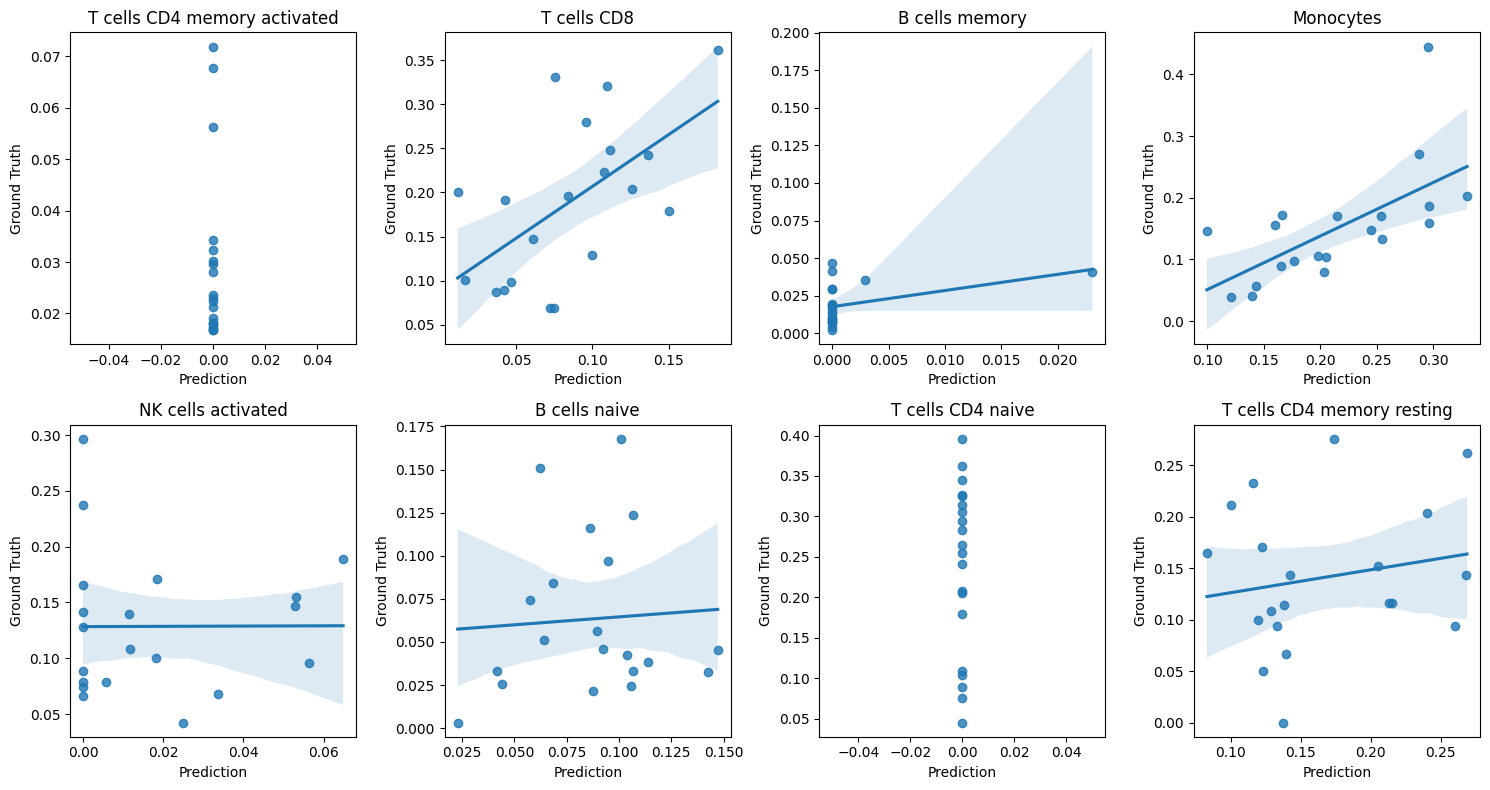

Mean Pearsonr    0.315595
Mean pvalue      0.380764
dtype: float64


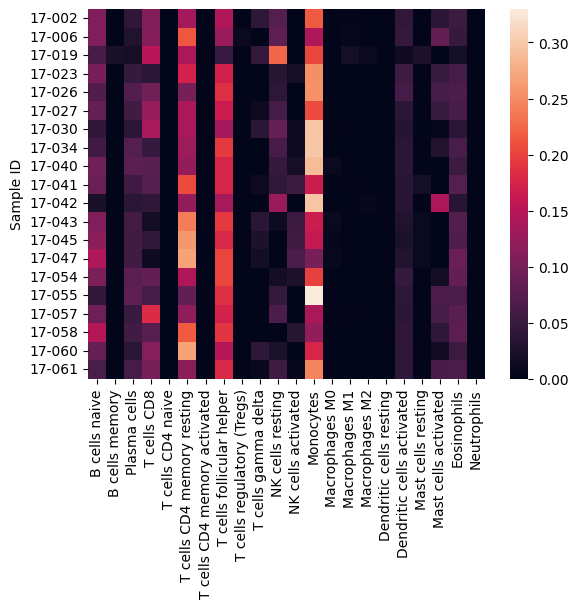

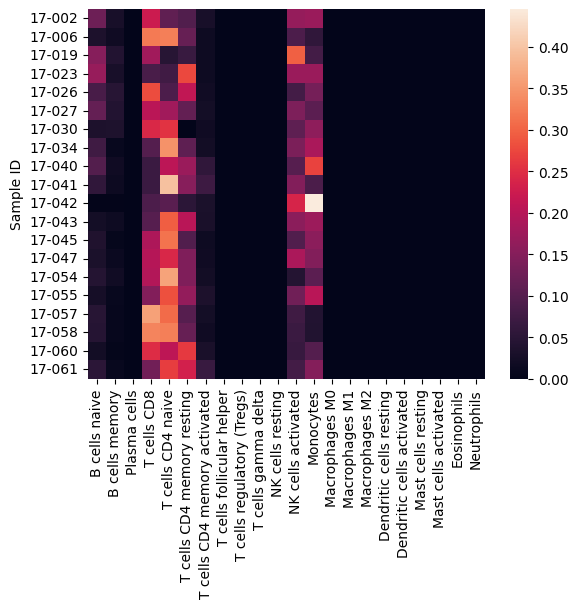

In [7]:
score_estimates(estimated_proportions, ground_truth)

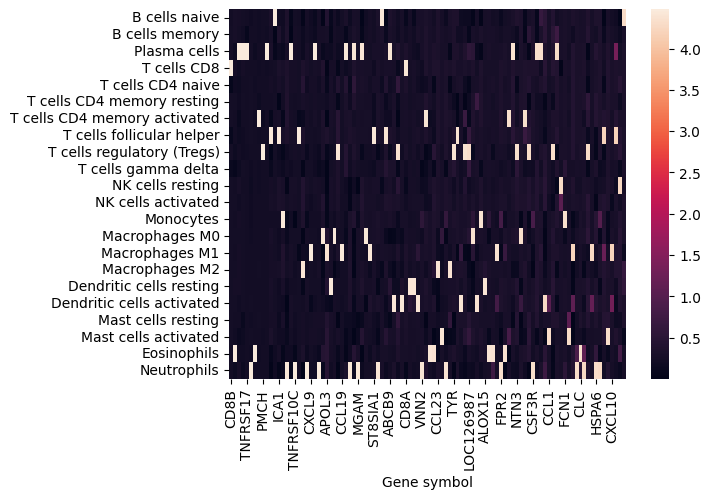

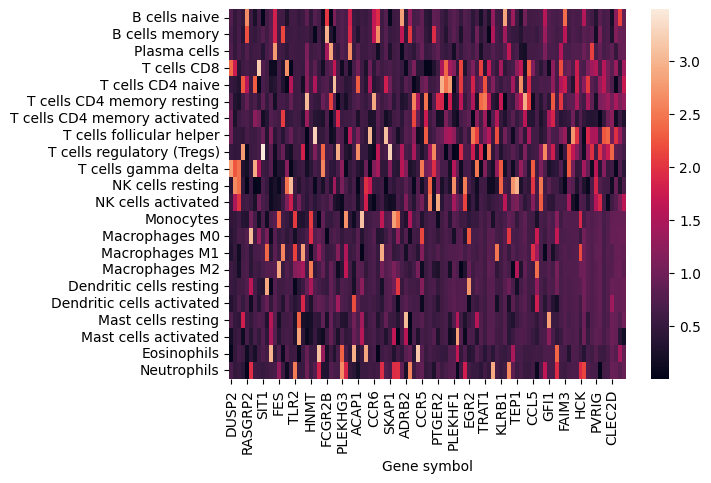

In [8]:
normalized_sm = abs((signature_matrix_common.T - signature_matrix_common.T.mean()) / signature_matrix_common.T.std())
genes_ranked_by_DE = normalized_sm.std().sort_values(ascending=False)  # type: ignore 
sns.heatmap(normalized_sm.T.loc[genes_ranked_by_DE.head(100).index.values].T)
plt.show()
sns.heatmap(normalized_sm.T.loc[genes_ranked_by_DE.tail(100).index.values].T)
plt.show()

In [9]:
def get_condition_number(X: pd.DataFrame) -> float:
    """
    The condition number of the data gives us an idea of how multi-collinear it is.
    A higher condition number means higher multicollinearity (in this case of 
    cell types).
    
    The idea is we look at the ratio between the largest and smallest 
    eigenvalues of the covariance matrix. If this ratio is high (some 
    eigenvalues are much bigger than others), then this means cell type variance 
    is getting concentrated into one eigenvector when we change to an orthogonal 
    basis, which is bad. Ideally we would prefer that the cell types _already_
    be an orthogonal basis, and no eigenvectors contain more variance than the
    original basis.

    Another way to think about it: we hope the covariance matrix of the 
    gene/cell-type matrix is the Identity matrix, which is also the matrix of
    lowest condition number.

    Adapted from: 
    https://github.com/statsmodels/statsmodels/blob/59a553e8102257a1f6c7bcd42e5fd1abd94c1c51/examples/python/ols.py#L189
    """
    # The first step is to normalize the independent variables to have unit length:
    norm_x = X.values
    for i, name in enumerate(X):
        norm_x[:, i] = X[name] / np.linalg.norm(X[name])  # type: ignore 
    norm_xtx = np.dot(norm_x.T, norm_x)

    # Then, we take the square root of the ratio of the biggest to the
    # smallest eigenvalues.
    eigs = np.linalg.eigvals(norm_xtx)
    condition_number = abs(np.sqrt(eigs.max() / eigs.min()))
    return condition_number

/var/folders/st/28t68bk15ks5j8v29x3_8x3m0000gp/T/ipykernel_27891/1719264054.py:31: RuntimeWarning: invalid value encountered in sqrt
  condition_number = abs(np.sqrt(eigs.max() / eigs.min()))


<Axes: >

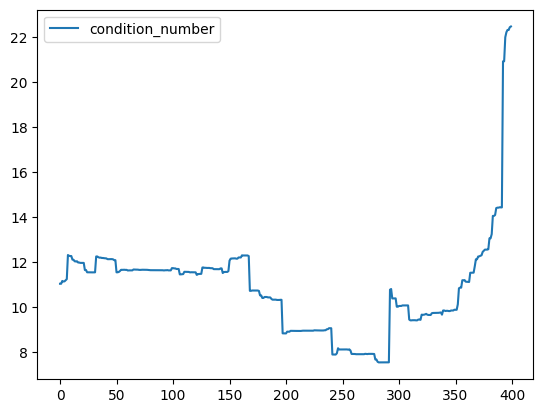

In [10]:
def generate_feature_selection_data(feature_ranking, X):
    """
    Return a dataframe of the summary stats for each feature set.
    """
    data = {}
    for i in range(feature_ranking.shape[0]):
        index = -1 * i if -1 * i != 0 else None
        feature_set = feature_ranking[:index].index
        X_filtered = X.loc[feature_set]
        condition_number = get_condition_number(X_filtered)
        data[i] = {
            'condition_number': condition_number, 
        } 
    return pd.DataFrame(data).T

df = generate_feature_selection_data(genes_ranked_by_DE, signature_matrix_common)
df.head(400).plot()

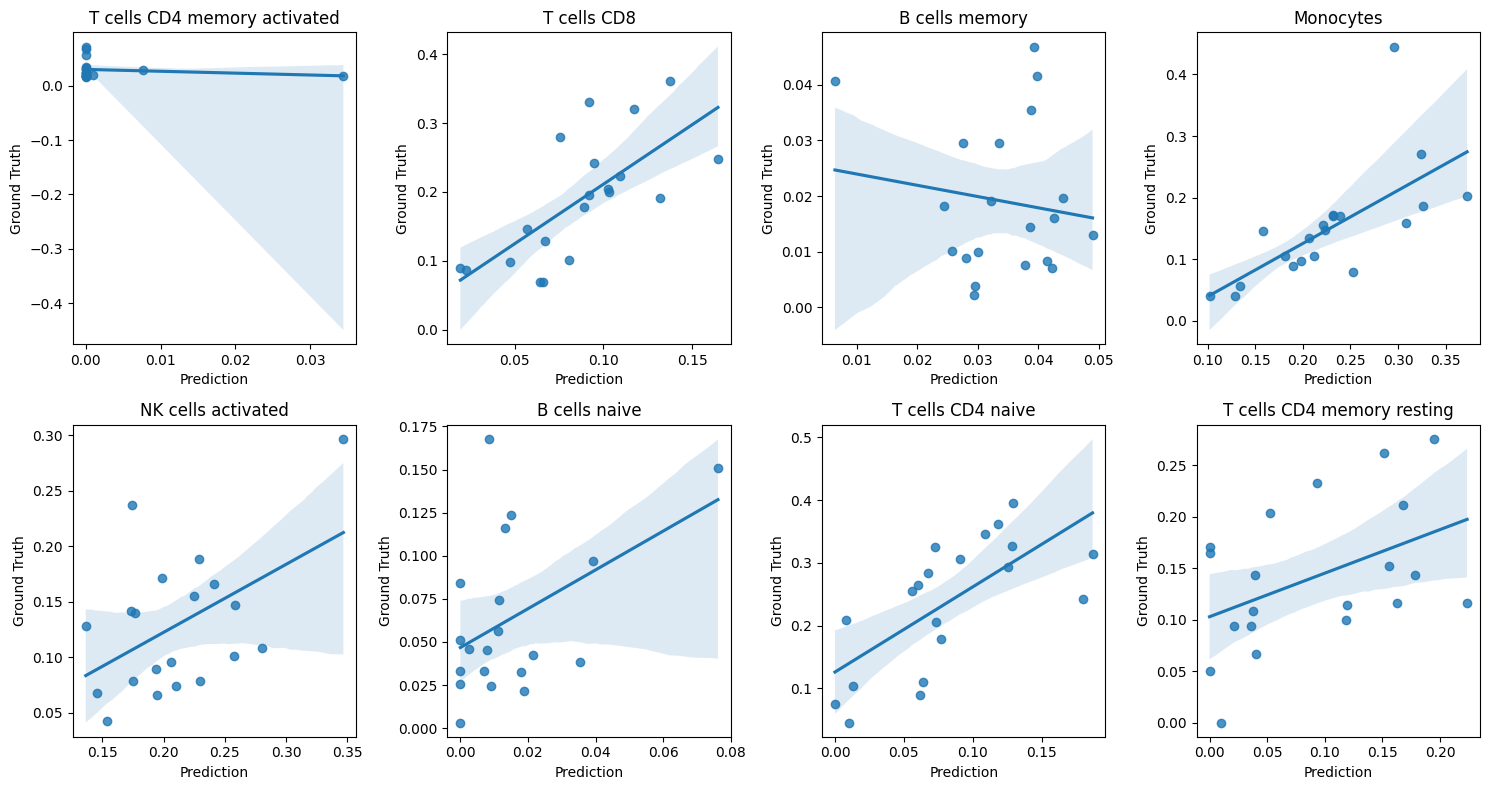

Mean Pearsonr    0.394087
Mean pvalue      0.146939
dtype: float64


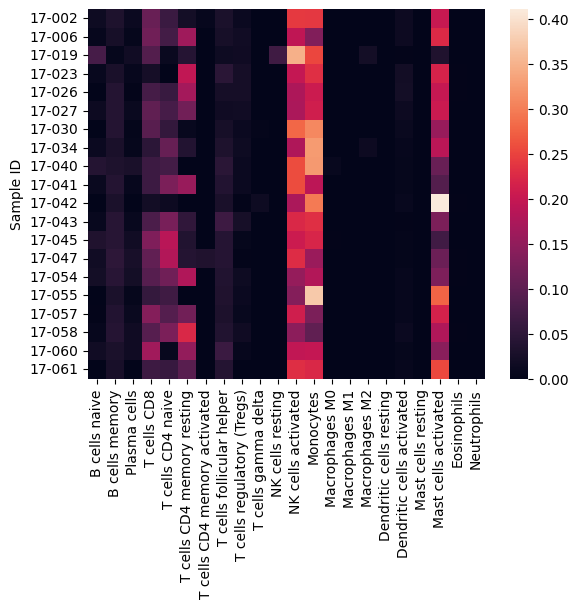

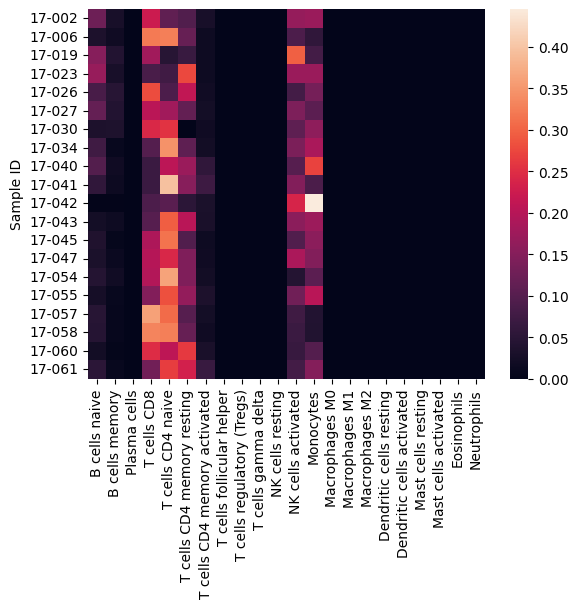

In [11]:
OPTIMAL_DE_RANKING_CUTOFF = 283
best_genes = genes_ranked_by_DE[:OPTIMAL_DE_RANKING_CUTOFF].index
# TODO: time vs .solve()
signature_matrix_filtered = signature_matrix.loc[best_genes]
cell_mixes_filtered = cell_mixes.loc[best_genes]
estimated_proportions = np.linalg.pinv(signature_matrix_filtered) @ cell_mixes_filtered
estimated_proportions.index = signature_matrix.columns   # type: ignore 
estimated_proportions.columns = ground_truth.T.columns   # type: ignore 
estimated_proportions[estimated_proportions < 0] = 0.0
estimated_proportions = estimated_proportions / estimated_proportions.sum()
# ensure the sum of all proportions is 1
assert (round(estimated_proportions.sum()) != 1).sum() == 0
score_estimates(estimated_proportions, ground_truth)

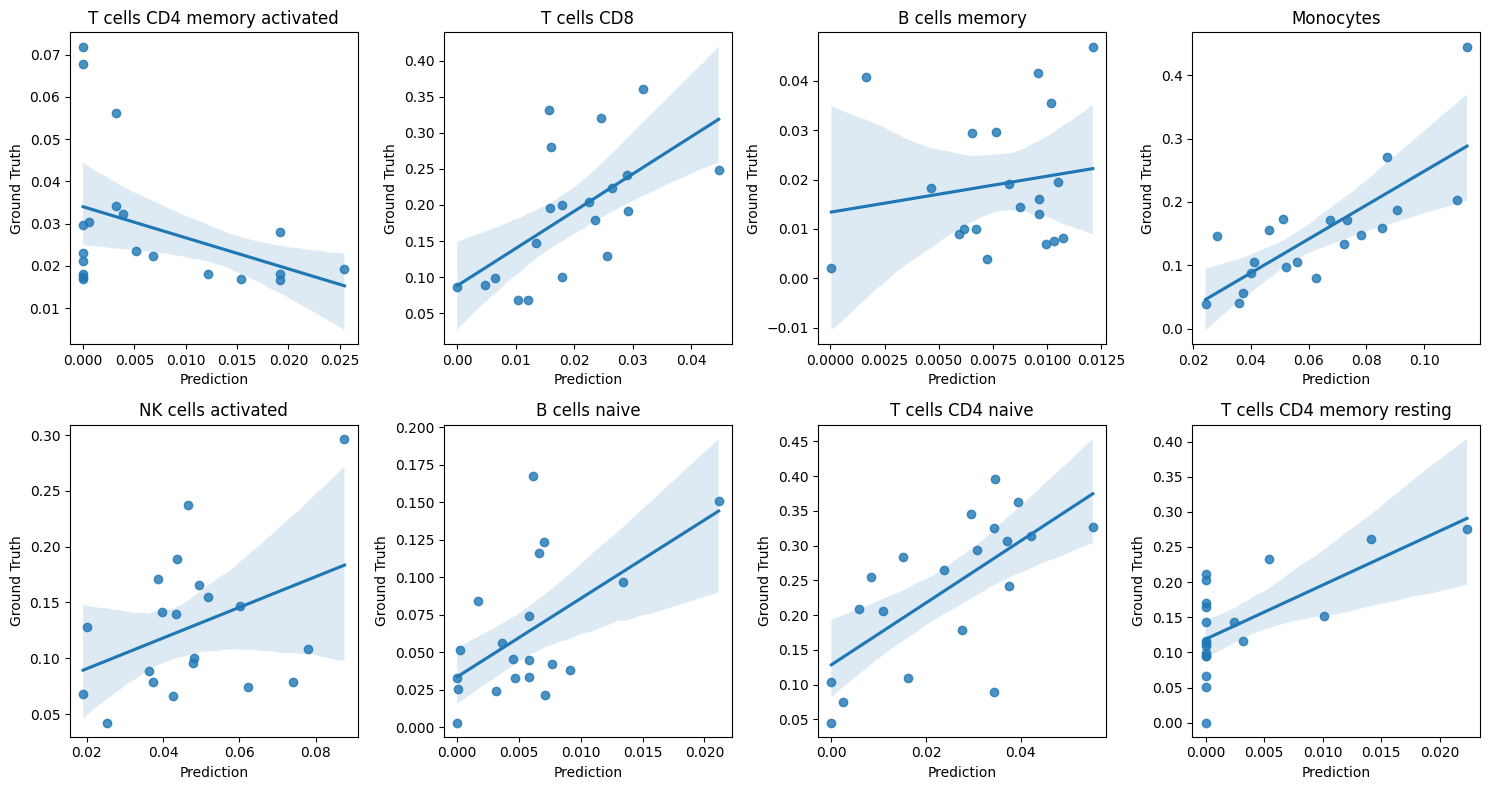

Mean Pearsonr    0.432826
Mean pvalue      0.087117
dtype: float64


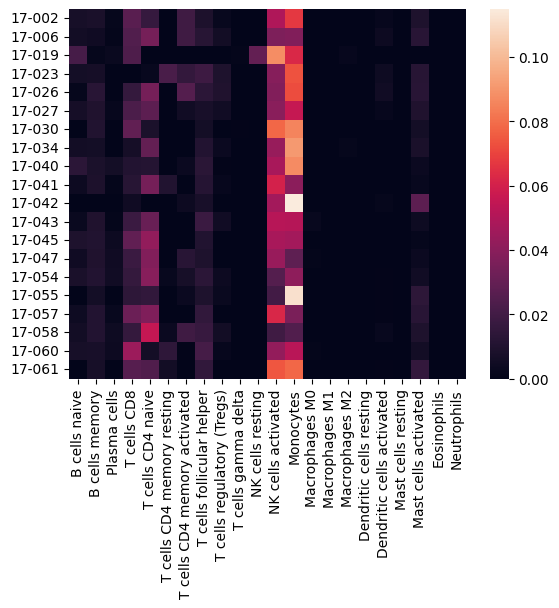

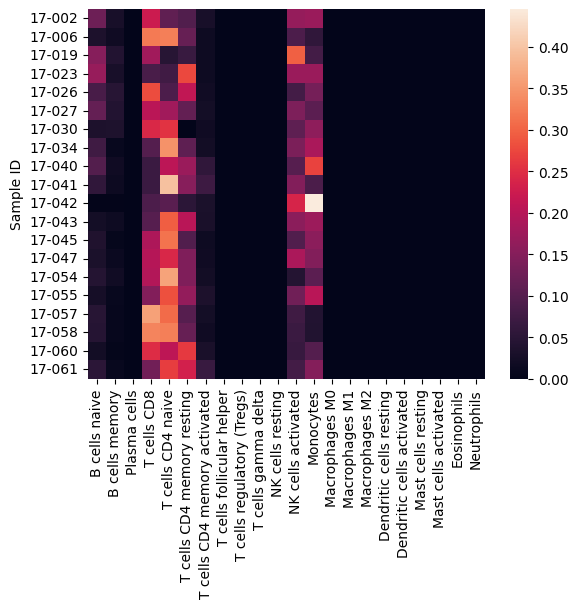

In [12]:
# NNLS similar to Gong et al.
model = LinearRegression(fit_intercept=False, positive=True)
model.fit(signature_matrix_filtered, cell_mixes_filtered)
estimated_proportions = pd.DataFrame(model.coef_).set_index(cell_mixes.columns).T.set_index(signature_matrix.columns)
score_estimates(estimated_proportions, ground_truth)

"Significantly differentially expressed genes between each population and all other populations were identified using a two-sided unequal variance t-test. Genes with a q-value < 0.3 (false discovery rate29) were considered significant."

- "While such methods perform accurately on distinct cell subsets in mixtures with well-defined composition (e.g., blood), they are considerably less effective for mixtures with unknown content and noise (e.g., solid tumors), and for discriminating closely related cell types (e.g., naïve vs. memory B cells)."
- Want a p-value and uncertainty

## Further considerations

"The most significant current limitation of CIBERSORT, and indeed all signature gene-based methods, is the fidelity of reference profiles, which could deviate in cells undergoing heterotypic interactions, phenotypic plasticity, or disease-induced dysregulation. Sampling a larger expression space by sorting populations from diverse physiological conditions (e.g., specific tumor-infiltrating immune cells) may mitigate this issue. Second, CIBERSORT currently does not provide P values for detection limits of individual cell types. Third, despite a considerably lower estimation bias than other approaches, some cell types were systematically over- or under-estimated by CIBERSORT (see RMSE values in Supplementary Table 4); efforts to address this are underway. Finally, while CIBERSORT was not explicitly tested on RNA-Seq data, the linearity assumptions made by our method are likely to hold, as previously suggested [17]."

### SVR

- Since since individual genes are "features", SVR actually does a feature selection, since points within the $\epsilon$-tube are not penalized.
- good for noisy data: https://www.sciencedirect.com/science/article/abs/pii/S0893608003001692?via%3Dihub
- ridge penalty combats multicollinearity because it penalizes large coefficients
- $\nu$ method: choose number of support vectors instead of tube size. https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html#sklearn.svm.NuSVR

All this amounts to automatic feature selection, which allows for more broadly applicable signature matrices: 
"Moreover, CIBERSORT does not require cell type-specific expression patterns for every gene, allowing the construction of signature matrices with more cell types and phenotypic states than other methods"
https://www.nature.com/articles/nmeth.3337/figures/11

"Group comparisons were determined using a two-sided Wilcoxon test, unpaired or paired, as appropriate."

In [55]:
data = []
for nu in np.linspace(.01, 1, 5):
    for C in np.logspace(-1, 2, 5):
        row = {}
        # TODO: may want to center data? Otherwise need to set max_iter to a 
        # very large number because default is unlimited and convergence too slowly
        svr_model = MultiOutputRegressor(NuSVR(nu=nu, C=C, kernel='linear', max_iter=1_000_000_000), n_jobs=-1)
        svr_model.fit(signature_matrix_common, cell_mixes_common)
        score =  svr_model.score(signature_matrix_common, cell_mixes_common)
        row['nu'] = nu
        row['C'] = C
        row['model'] = svr_model
        row['score'] = score
        data.append(row)

models = pd.DataFrame(data).sort_values('score', ascending=False)

/Users/luke/projects/cell-type-deconvolution/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/luke/projects/cell-type-deconvolution/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/luke/projects/cell-type-deconvolution/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/luke/projects/cell-type-deconvolution/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000000000).  Consider pre-processing your data with S

KeyboardInterrupt: 

<Axes: xlabel='nu', ylabel='C'>

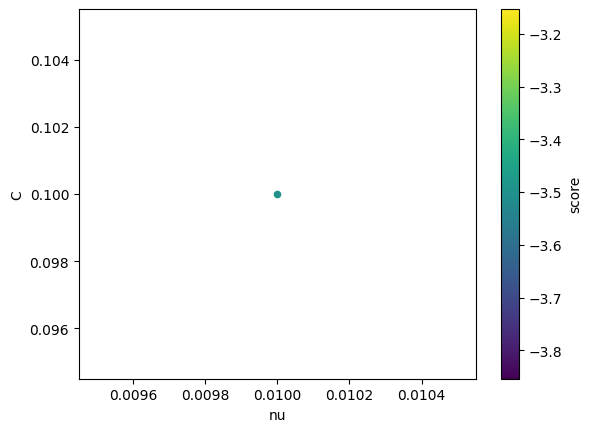

In [ ]:
models.plot.scatter(x='nu', y='C', c='score', colormap='viridis')

In [ ]:
best_model = models['model'].iloc[0]
estimated_proportions_svr = pd.DataFrame([m.coef_[0] for m in best_model.estimators_]).T
estimated_proportions_svr.index = signature_matrix_common.columns   # type: ignore 
estimated_proportions_svr.columns = ground_truth.T.columns   # type: ignore 
estimated_proportions_svr[estimated_proportions_svr < 0] = 0
estimated_proportions_svr = estimated_proportions_svr / estimated_proportions_svr.sum()
score_estimates(estimated_proportions_svr, ground_truth)